# 1. Install Required Packages

In [ ]:
! pip install transformers==4.44.2 datasets==3.1.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 138.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Imports

In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Processor, Wav2Vec2Model

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 2. Set Up Environment

In [ ]:
device =  "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 3. Loading and Processing Data

In [ ]:
ds_path = "facebook/voxpopuli"
dataset = load_dataset(ds_path, "sl", split="train", streaming=True, trust_remote_code=True) # sl-slovene

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

In [ ]:
dataset = dataset.shuffle(seed=42)

In [ ]:
torch.manual_seed(42)

# 4. Feature Extraction Using Wav2Vec2

**Loading Model and Processor**: Load the Wav2Vec2 model and processor from Hugging Face’s transformers library to extract audio features. Use the pretrained model

In [ ]:
# Laod the Wav2Vec processor and model
model_id="facebook/wav2vec2-base-960h"
processor=Wav2Vec2Processor.from_pretrained(model_id)
model=Wav2Vec2Model.from_pretrained(model_id)
model.to(device);

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Feature Extraction Function**: Define a function to process each audio sample and extract its feature representation. Apply this function to obtain Wav2Vec2 embeddings for the dataset.

In [ ]:
call_count=0
def extract_wav2vec_features(batch):
    global call_count
    call_count+=1
    print(call_count)
    inputs=processor(batch["audio"]["array"], sampling_rate=16000,return_tensors="pt",padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return {"features": outputs.last_hidden_state.squeeze().cpu().numpy(), "label":batch["speaker_id"]}

In [ ]:
# dataset

In [ ]:
# Q1: What is the length of the dataset?

count = 0
for ex in dataset:
    count+=1
print(count)

2099


In [ ]:
# Extract Wav2Vec features for the dataset

subset_with_features = [extract_wav2vec_features(example) for example in dataset]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
# x = extract_wav2vec_features(next(iter(dataset)))

In [ ]:
# import pickle

# with open('sample_data/data.pkl', 'wb') as file:
#     pickle.dump(subset_with_features, file)


In [ ]:
subset_with_features[0]["features"].shape

(324, 768)

In [ ]:
# Q2: What is the minimum feature length (frame length) from the wav2vec for the given dataset?

# Q3: What is the maximum feature length from the wav2vec for the given dataset?

sizes = []
for x in subset_with_features:
    sizes.append(x["features"].shape[0])

print(min(sizes))
print(max(sizes))

27
1948


# 5. Data Filtering and Label Mapping

**Filtering Short Samples**: Exclude samples with fewer than 200 frames.

In [ ]:
filtered_ds = []

for v in subset_with_features:
    if v["features"].shape[0] >= 200:
        filtered_ds.append(v)


In [ ]:
# Q4: What is the length of the filtered dataset ?

print(len(filtered_ds))

1937


In [ ]:
# Q5: What is the speaker ID of the first example of the filtered dataset?

filtered_ds[0]["label"]

'97019'

**Label Mapping**: Assign each unique speaker an integer label. Sort the speaker list using the


```
sorted
```

In [ ]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for row in filtered_ds:
    speaker_counts[int(row["label"])]+=1

In [ ]:
# Q6: What is the number of unique speakers in the filtered dataset?

len(speaker_counts)

12

In [ ]:
speakers = sorted(speaker_counts, )
speakers

[23693,
 28294,
 96911,
 96933,
 97019,
 125003,
 125004,
 125103,
 125104,
 197446,
 197447,
 197452]

In [ ]:
label_mapping = {label:id for id, label in enumerate(speakers)}

In [ ]:
label_mapping

{23693: 0,
 28294: 1,
 96911: 2,
 96933: 3,
 97019: 4,
 125003: 5,
 125004: 6,
 125103: 7,
 125104: 8,
 197446: 9,
 197447: 10,
 197452: 11}

# 6. Model Definition

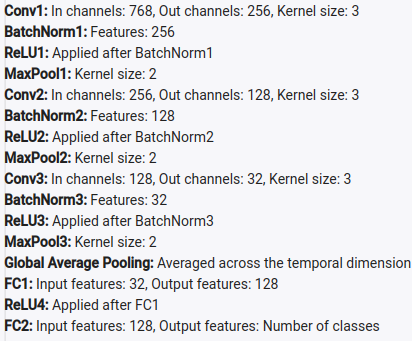


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(256)

        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(32)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, kernel_size=2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, kernel_size=2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool1d(x, kernel_size=2)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


# 7. Data Splitting and DataLoader

**Data Splitting**: Split the data into training, validation, and test sets using sklearn. Divide the dataset by taking 80% for train and 20% for test. Then take another 10% of the train data for valid set. Set random state to 42 and use sklearn for this stage.

In [ ]:
subset_with_features[0]["features"][:200, :].shape

(200, 768)

In [ ]:
# split the dataset into train, validation and test set

train_data, test_data = train_test_split(filtered_ds, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# extract features and labels

def prepare_data(data):
    features = [item["features"] for item in data]
    labels = [label_mapping[int(item["label"])] for item in data]
    return features, labels

train_features, train_labels = prepare_data(train_data)
val_features, val_labels = prepare_data(val_data)
test_features, test_labels = prepare_data(test_data)

In [ ]:
# Q7: What is the length of train dataset?
print(len(train_features))

1394


**DataLoader**: Use PyTorch’s DataLoader with a custom collate function to convert features and labels to tensors, truncating features to the first 200 frames. Batch sizes:
Train: 100
Validation: 10
Test: 1

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

def collate_fn(batch):
    features, labels = zip(*batch)

    features = [torch.tensor(feature[:200, :]) for feature in features]

    labels = torch.tensor(labels)

    features = torch.stack(features).transpose(-2, -1)#
    return features, labels

# Load the dataset
train_dataset = CustomDataset(train_features, train_labels)
val_dataset = CustomDataset(val_features, val_labels)
test_dataset = CustomDataset(test_features, test_labels)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Q8: What is the number of batches in train data?

len(train_loader)

14

In [ ]:
# for x,y in train_loader:
#     print(x.shape)

# 8. Training the Model

**Loss and Optimizer**: Use cross-entropy loss and Adam optimizer with a learning rate of

```
0.001
```

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch.optim as optim
model = CNNModel(num_classes=len(label_mapping))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device);

**Training Loop**: Train for 100 epochs.

For each epoch:

Set the model to training mode.

Zero the optimizer’s gradient.

For each batch, forward propagate, calculate loss, and backpropagate.

Track average loss for the epoch.

**Validation**: Evaluate on the validation set after each epoch by calculating loss without weight updates. Track validation loss to monitor performance.

In [ ]:
device

'cuda'

In [ ]:
def train(epochs=100):
    avg_train_loss = []
    avg_val_loss = []
    for epoch in range(epochs):
        model.train()
        with torch.enable_grad():
            los = []
            for features, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(features.to(device))
                loss = criterion(outputs, labels.to(device))
                loss.backward()
                optimizer.step()
                los.append(loss)
                features.to("cpu")
                labels.to("cpu")
            avg_train_loss.append(sum(los)/len(los))

        model.eval()
        with torch.no_grad():
            los = []
            for features, labels in val_loader:
                val_outputs = model(features.to(device))
                val_loss = criterion(val_outputs, labels.to(device))
                los.append(val_loss)
                features.to("cpu")
                labels.to("cpu")
            avg_val_loss.append(sum(los)/len(los))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    return avg_train_loss, avg_val_loss

In [ ]:
epochs = 100
avg_train_loss, avg_val_loss = train(epochs)

Epoch 1/100, Loss: 2.090548276901245, Val Loss: 2.31787371635437
Epoch 2/100, Loss: 1.8275127410888672, Val Loss: 1.738093376159668
Epoch 3/100, Loss: 1.5759905576705933, Val Loss: 1.5590441226959229
Epoch 4/100, Loss: 1.323672890663147, Val Loss: 1.2896912097930908
Epoch 5/100, Loss: 1.0922592878341675, Val Loss: 1.3114473819732666
Epoch 6/100, Loss: 0.894622802734375, Val Loss: 1.381459355354309
Epoch 7/100, Loss: 0.7388368248939514, Val Loss: 1.2614195346832275
Epoch 8/100, Loss: 0.5922045111656189, Val Loss: 1.2006680965423584
Epoch 9/100, Loss: 0.4714662730693817, Val Loss: 1.5689952373504639
Epoch 10/100, Loss: 0.44916555285453796, Val Loss: 0.805509090423584
Epoch 11/100, Loss: 0.3948543667793274, Val Loss: 0.6846342086791992
Epoch 12/100, Loss: 0.2581173777580261, Val Loss: 1.570839762687683
Epoch 13/100, Loss: 0.19866973161697388, Val Loss: 1.7649633884429932
Epoch 14/100, Loss: 0.12715883553028107, Val Loss: 1.4924108982086182
Epoch 15/100, Loss: 0.11025341600179672, Val Loss

# 9. Evaluating on the Test Set

Set the model to evaluation mode. Compute class predictions for each test sample, calculate accuracy using `sklearn`'s

```
accuracy_score
```


 and display the test accuracy.

In [ ]:
y_val = []
y_pred_val = []
model.eval()
with torch.no_grad():
    for features, labels in val_loader:
        val_outputs = model(features.to(device))
        _, predicted = torch.max(val_outputs, 1)

        features.to("cpu")
        y_val.extend(labels)
        y_pred_val.extend(predicted.cpu())

accuracy = accuracy_score(y_val, y_pred_val)
print(f"Val Accuracy: {accuracy * 100:.2f}%")

Val Accuracy: 64.52%


In [ ]:
# model in evaluation mode

model.eval()

y_test = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        # forward pass to get predictions
        test_outputs = model(x.float().to(device))

        # get the predicted class labels
        _, predicted = torch.max(test_outputs, 1)
        x.to("cpu")
        y_test.append(y)
        y_pred.append(predicted.to("cpu"))
        # calculate accuracy

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 73.20%
